In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models

# Set the image size
img_size = (64, 64)


In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(folder_path, img_size):
    """
    Loads all images from the specified folder, resizes them to `img_size`, 
    and converts them to NumPy arrays normalized to [0, 1].

    Args:
        folder_path (str): Path to the folder containing images.
        img_size (tuple): Target size for resizing images (height, width).

    Returns:
        np.array: Array of processed images.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"❌ Folder '{folder_path}' not found! Check the path.")

    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        
        # Ensure it's an image file
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
    
    if len(images) == 0:
        raise ValueError(f"❌ No images found in '{folder_path}'. Ensure images are in PNG/JPG format.")

    return np.array(images)

# ✅ Set image folder path (Your provided path)
folder_path = r"E:\dataset\dataset\A-samples"  # Update this path if needed
img_size = (224, 224)  # Adjust based on model requirements

# ✅ Load images
try:
    images = load_images(folder_path, img_size)
    print(f"✅ Successfully loaded {len(images)} images with shape: {images.shape}")
except Exception as e:
    print(str(e))


✅ Successfully loaded 101 images with shape: (101, 224, 224, 3)


In [5]:
def build_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')  # Adjust output units for your classification task
    ])
    return model

# Build and summarize the model
input_shape = (img_size[0], img_size[1], 3)
cnn_model = build_cnn_model(input_shape)
cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       5,537,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,631,754 (21.48 MB)

 Trainable params: 5,631,754 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

1/1 [==============================] - 0s 218ms/step


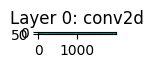

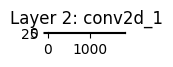

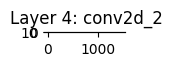

In [6]:
def visualize_feature_maps(model, images, layer_indices):
    # Create a model that gives output at each convolutional layer
    layer_outputs = [model.layers[i].output for i in layer_indices]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    
    # Pick a random image from the dataset
    img = images[np.random.randint(len(images))]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Get feature maps
    feature_maps = activation_model.predict(img)
    
    for layer_idx, fmap in zip(layer_indices, feature_maps):
        num_filters = fmap.shape[-1]
        size = fmap.shape[1]
        
        # Display all feature maps in this layer
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            fmap_img = fmap[0, :, :, i]
            fmap_img -= fmap_img.mean()
            fmap_img /= (fmap_img.std() + 1e-5)
            fmap_img *= 64
            fmap_img += 128
            fmap_img = np.clip(fmap_img, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = fmap_img
        
        # Plot the feature maps
        scale = 1.0 / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(f'Layer {layer_idx}: {model.layers[layer_idx].name}')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Select layers to visualize (all convolutional layers)
layer_indices = [0, 2, 4]
visualize_feature_maps(cnn_model, images, layer_indices)


In [6]:
def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Adjust output units for classification
    ])
    return model

# Define input shape and number of classes
input_shape = (img_size[0], img_size[1], 3)
num_classes = 10  # Change this to match your dataset

# Build and summarize the model
custom_cnn = build_custom_cnn(input_shape, num_classes)
custom_cnn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       4,718,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,108,426 (19.49 MB)

 Trainable params: 5,108,426 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
custom_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Dummy labels for illustration. Replace with your actual labels.
labels = np.random.randint(0, num_classes, len(images))

# One-hot encode labels
labels = to_categorical(labels, num_classes)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Training set: (80, 224, 224, 3), Validation set: (21, 224, 224, 3)


In [10]:
history = custom_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1797 - loss: 2.6431 - val_accuracy: 0.1905 - val_loss: 2.2709
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 532ms/step - accuracy: 0.0789 - loss: 2.2982 - val_accuracy: 0.1905 - val_loss: 2.2927
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - accuracy: 0.1914 - loss: 2.2835 - val_accuracy: 0.1905 - val_loss: 2.2814
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step - accuracy: 0.1953 - loss: 2.2243 - val_accuracy: 0.1905 - val_loss: 2.3054
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 547ms/step - accuracy: 0.2680 - loss: 2.1931 - val_accuracy: 0.1905 - val_loss: 2.3377
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.1914 - loss: 2.2509 - val_accuracy: 0.1905 - val_loss: 2.2759
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.1781 - loss: 2.2599 - val_accuracy: 0.1905 - val_loss: 2.2730
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 0.2250 - loss: 2.2113 - val_accuracy: 0.1905 - val_loss: 2.

In [11]:
# Evaluate model performance
val_loss, val_accuracy = custom_cnn.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.1905 - loss: 2.2973
Validation Accuracy: 19.05%


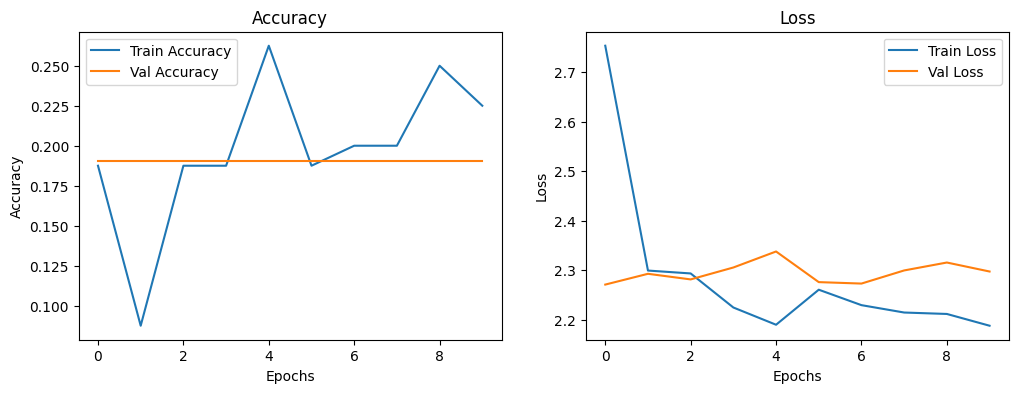

In [12]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
